# Helmholtz 1D - AutoAMG on a Fixed Domain Size - Multilevel

## Goal
Given the Helhmholtz operator $A = \Delta + k^2 I$ on a fixed domain with periodic boundary conditions, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, and a multilevel hierarchy that is able to solve $A u = f$ fast.

In general, $k=k(x)$ varies over the domain. In thesse experiments, $k$ is constant, but we do not assume this knowledge.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. In this experiment we use a fixed periodic domain with $n=96$ points and a small $kh=0.5$.

In [1]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm
from scipy.sparse.linalg import eigs

import helmholtz as hm
import helmholtz.setup.hierarchy as hierarchy

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

## Finest-level Eigenvalues

Smallest-magnitude eigenvalue -5.770850586968641e-10


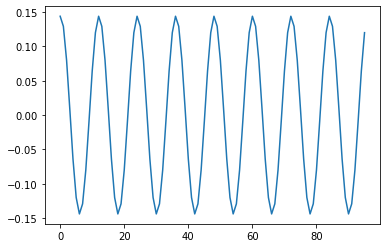

In [2]:
n = 96
#kh = 0.5
# Exactly 12 gridpoints per wavelength.
kh = 0.52338538
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

lam, v = eig(a.todense())
lam = np.real(lam)
ind = np.argsort(np.abs(lam))
lam = lam[ind]
v = v[:, ind]
print("Smallest-magnitude eigenvalue", lam[0])
plt.plot(v[:, 0]);

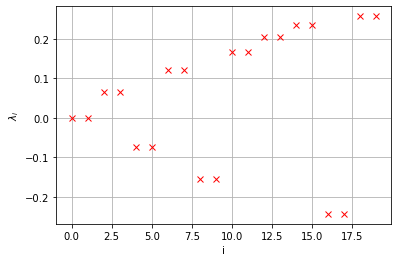

In [3]:
plt.plot(lam[:20], "rx")
plt.grid(True)
plt.xlabel("i")
plt.ylabel(r"$\lambda_i$");

## Two-level Bootstrap
We perform 4 bootstrap cycles, starting from 20 random test functions.
* R is constructed by SVD.
<!-- * P is contructed by regularized LS. -->
* P = R^T.
We measure the Residual to Error Ratio (RER) of test functions the two-level cycle convergence factor for $A x = 0$ (solving exactly at the coarse level), with $\nu_1+\nu_2=4$ relaxations per cycle 

In [4]:
# Fixed seed for reproducible results.
np.random.seed(0)

num_examples = 25
max_levels = 2
num_bootstrap_steps = 3
threshold = 0.1
interpolation_method = "svd" # "ls"
num_sweeps = 10

In [5]:
# # Initialize test functions (to random) and hierarchy at coarsest level.
# level = hierarchy.create_finest_level(a)
# multilevel = hm.hierarchy.multilevel.Multilevel(level)

# x, multilevel = hm.setup.auto_setup.setup(a, max_levels=3, num_bootstrap_steps=num_bootstrap_steps, num_examples=20,
#                               interpolation_method="svd", threshold=0.1)

## Level 0->1: Two-level Coarsening + Bootstrapping

In [6]:
_LOGGER = logger
x_log = {}

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
level = hierarchy.create_finest_level(a)
multilevel = hm.hierarchy.multilevel.Multilevel(level)
# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log[1] = []
x_log[1].append(x)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros_like(x)
x, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x,num_sweeps=num_sweeps)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log[1].append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("-" * 80)
_LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
x_log[num_levels] = [x]
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 1,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
    x_log[num_levels].append(x)
    _LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x2 = x

INFO     Relax at level 0 size 96
INFO     Relax convergence factor 0.843
INFO     RER 0.308
INFO     --------------------------------------------------------------------------------
INFO     bootstrap with 96 levels
INFO     Bootstrap step 1/3
INFO     Relax cycle conv factor 0.994 asymptotic RQ 0.228 RER 0.261 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     Agg [4 4 4 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     nc  [2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
INFO     Energy error mean 0.0745 max 0.0980
INFO     Mock cycle conv factor [0.575 0.323 0.193 0.135 0.143 0.125 0.084 0.07  0.065 0.06  0.058]
INFO     fit  set size 20 P error mean 0.07 max 0.09
INFO     test set size 5  P error mean 0.09 max 0.10
INFO     Level 1 size 48
INFO     RER 0.165
INFO     Bootstrap step 2/3
INFO     Relax cycle conv factor 0.932 asymptotic RQ -0.033 RER 0.134 P error 0.059
INFO     Improving vectors by relaxation cycles
INFO     Coarse

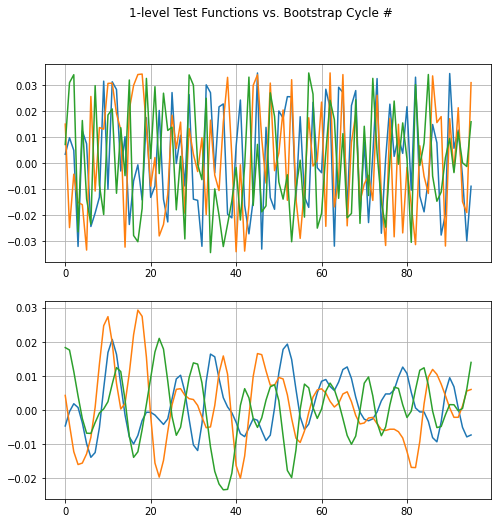

In [7]:
x_all = x_log[1]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('1-level Test Functions vs. Bootstrap Cycle #')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

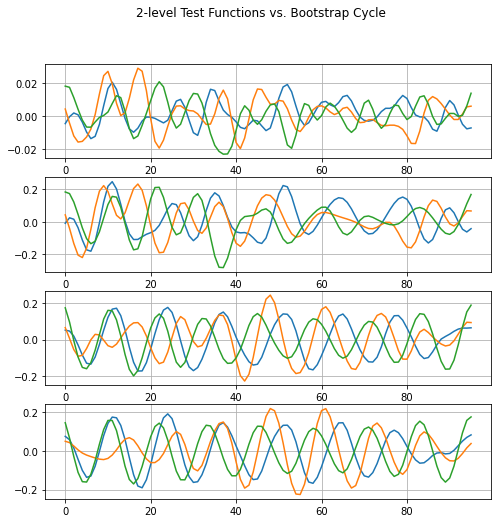

In [8]:
x_all = x_log[2]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('2-level Test Functions vs. Bootstrap Cycle')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

In [9]:
# # Bootstrap 3 levels.
# x = x2
# num_levels = 3
# _LOGGER.info("-" * 80)
# _LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
# x_log[num_levels] = [x]
# for i in range(num_bootstrap_steps):
#     _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
#     x, multilevel = hm.setup.auto_setup.bootstap(x, multilevel, num_levels, num_sweeps=num_sweeps,
#                              interpolation_method=interpolation_method, threshold=threshold)
#     x_log[num_levels].append(x)
#     _LOGGER.info("RER {:.2f}".format(norm(a.dot(x)) / norm(x)))

In [10]:
# x_all = x_log[3]
# fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
# fig.suptitle('2-level Test Functions vs. Bootstrap Cycle')
# for i, x in enumerate(x_all):
#     ax = axs[i]
#     for j in range(5):
#         ax.plot(x[:, j])
#     ax.grid(True);

## Level 1->2: Two-level Coarsening + Bootstrapping

In [11]:
level = multilevel.level[1]
a1 = level.a
x = level.coarsen(x2)
np.random.seed(0)

# x1_improved, multilevel1 = hm.setup.auto_setup.setup(a1, max_levels=2, 
#                                                      num_bootstrap_steps=5,
#                                                      num_sweeps=30, print_frequency=3,
#                                                      num_examples=num_examples, 
#                                                      interpolation_method=interpolation_method, 
#                                                      threshold=threshold, x=x1)

_LOGGER = logger
x_log = {}

# Initialize hierarchy to 1-level and fine-level test functions from finer level.
finest = 0
multilevel1 = hm.hierarchy.multilevel.Multilevel(level)
x_log[1] = []
x_log[1].append(x)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros_like(x)
print(x.shape, b.shape, level.size)
x, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))
_LOGGER.info("RER {:.3f}".format(norm(a1.dot(x)) / norm(x)))
x_log[1].append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("-" * 80)
_LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
x_log[num_levels] = [x]
num_bootstrap_steps = 4
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    x, multilevel1 = hm.setup.auto_setup.bootstap(
        x, multilevel1, num_levels, relax_conv_factor,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold,
        print_frequency=1)
    x_log[num_levels].append(x)
    _LOGGER.info("RER {:.3f}".format(norm(a1.dot(x)) / norm(x)))

INFO     Relax at level 0 size 48
(48, 25) (48, 25) 48
INFO     Relax convergence factor 0.991
INFO     RER 0.062
INFO     --------------------------------------------------------------------------------
INFO     bootstrap with 48 levels
INFO     Bootstrap step 1/4
INFO         0 |r| 4.35531040e+00 RER 1.02813
INFO         1 |r| 1.80338600e-01 (0.04141) RER 0.18034 (0.17540) 1.00000
INFO         2 |r| 1.49395510e-01 (0.82842) RER 0.14940 (0.82842) 1.00000
INFO         3 |r| 1.35074819e-01 (0.90414) RER 0.13507 (0.90414) 1.00000
INFO         4 |r| 1.27981410e-01 (0.94749) RER 0.12798 (0.94749) 1.00000
INFO         5 |r| 1.23988850e-01 (0.96880) RER 0.12399 (0.96880) 1.00000
INFO         6 |r| 1.21366259e-01 (0.97885) RER 0.12137 (0.97885) 1.00000
INFO         7 |r| 1.19367564e-01 (0.98353) RER 0.11937 (0.98353) 1.00000
INFO         8 |r| 1.17651608e-01 (0.98562) RER 0.11765 (0.98562) 1.00000
INFO         9 |r| 1.16056566e-01 (0.98644) RER 0.11606 (0.98644) 1.00000
INFO        10 |r| 1.1

* Even though the test function RER decreases, the two-level convergence factor is excellent after one bootstrap cycle, then gets worse.
* Even though $R$ is accurate in the energy norm (i.e., the coarse values reconstruct the value of the fine variables to $10\%$ error), theer exist test functions (not used in the fit) with large interpolation error ($100\%$!).

In [12]:
x_all = [x1, x1_improved]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('2-level Test Functions vs. before and after Bootstrap')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(5):
        ax.plot(x[:, j])
    ax.grid(True);

NameError: name 'x1' is not defined

In [ ]:
# Append level 2 found by 1->2 coarsening into the hierarchy of level 0.
#multilevel.level.append(multilevel1.level[1])
multilevel.level.append(multilevel1.level[1])

## Relaxation Cycle Convergence Factor vs. #levels

In [ ]:
# 1-level: 4 relaxations = 1 iteration so we can compare with a relaxation cycle.
level = multilevel.level[0]
b = np.zeros((level.size, ))

y_all = {}
for num_levels in range(1, len(multilevel.level) + 1):
    print("#levels", num_levels)
    if num_levels == 1:
        def relax_cycle(x):
            for i in range(4):
                x = level.relax(x, b)
            return x
    else:
        def relax_cycle(x):
            return hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, 2, 2, 4, num_levels=num_levels).run(x)
    y, conv_factor = hm.solve.run.run_iterative_method(
        level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
        10, print_frequency=1)
    y_all[num_levels] = y
    print("Conv Factor {:.5f}".format(conv_factor))

In [ ]:
# Asymptotic vector of 3-level relaxation cycle is a smooth component.
coarse_level = multilevel.level[1]
p = coarse_level.p
r = coarse_level.r
y = y_all[3].flatten()
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
plt.plot(y, label="$y$")
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);
print(norm(y - correction) / norm(y))

### Level 1->2 Relaxation Cycle

In [ ]:
# 1-level: 4 relaxations = 1 iteration so we can compare with a relaxation cycle.
l = 1
level = multilevel.level[l]
b = np.zeros((level.size, ))
ml = hm.hierarchy.multilevel.Multilevel(level)
ml.level = multilevel.level[l:]

y_all = {}
for num_levels in range(1, len(ml.level) + 1):
    print("#levels", num_levels)
    if num_levels == 1:
        def relax_cycle(x):
            for i in range(4):
                x = level.relax(x, b)
            return x
    else:
        def relax_cycle(x):
            return hm.solve.relax_cycle.relax_cycle(ml, 1.0, 2, 2, 4, num_levels=num_levels).run(x)
    y, conv_factor = hm.solve.run.run_iterative_method(
        level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
        10,  print_frequency=1)
    y_all[num_levels] = y
    print("Conv Factor {:.5f}".format(conv_factor))

In [ ]:
# Asymptotic vector of 2-level relaxation cycle at level 1 is still smooth.
coarse_level = ml.level[1]
p = coarse_level.p
r = coarse_level.r
y = y_all[2].flatten()
plt.plot(y, label="$y$")
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);
print(norm(y - correction) / norm(y))

### Fine vs. Coarse Operator Eigenvalues

In [ ]:
lam = [None] * len(multilevel)
v = [None] * len(multilevel)
for l in range(len(multilevel)):
    level = multilevel.level[l]
    lam[l], v[l] = eig(level.a.todense(), b=level.b.todense())
    lam[l] = np.real(lam[l])
    ind = np.argsort(np.abs(lam[l]))
    lam[l] = lam[l][ind]
    v[l] = v[l][:, ind]

In [ ]:
k = 20
lf = lam[0][:k][:, None] 
lc = lam[1][:k][:, None]
l2 = lam[2][:k][:, None]

plt.plot(lf, 'rx', label="$\lambda_i^0$")
plt.plot(lc, 'bx', label="$\lambda_i^1$")
plt.plot(lc, 'gx', label="$\lambda_i^2$")
plt.xlabel("i")
plt.grid(True)
plt.title("Operator Eigenvalues ({} smallest-magnitude)".format(k));
plt.legend();
#plt.xlim([-0.3, 0.3]);
#plt.ylim([-0.1, 0.1]);

In [ ]:
pd.DataFrame(np.concatenate((lf, lc, l2,
                             np.abs(lc - lf)/np.abs(lf), np.abs(l2 - lf)/np.abs(lf),
                            ),  axis=1),
            columns=("lam0", "lam1", "lam2", "rel error 1", "rel error 2"))

In [ ]:
# Lowesst eigenfunction at levels 0..2.
plt.plot(v[0][:, 0])
plt.plot(v[1][:, 0])
plt.plot(v[2][:, 2])
plt.grid(True);
print("Eigenvalue", lam[0][0], lam[1][0], lam[2][2])

## Observations
#### 2-level
* We get a good result: mock cycle rates are good and improve with #relaxation sweeps (0.53, 0.33, 0.2, ...).
* The test function RER decreases with bootstrap cycles.
* The two-level relaxation cycle is able to reduce the residual faster than 1-level relaxation.

#### 3-level
* The mock cycle rates are much larger, but still improve with the number of relaxation sweeps, indicating that Kaczmarz is a less effective smoother for the level 1 equations than level 0 (~0.85, 0.81, 0.79, ...) and that we need more relaxations at level 1 during a cycle.
* The test function RER oscillates with bootstrap cycles.
* The 3-level relaxation cycle RER does not converge to the smallest eigenvalue. This indicates that there is a error component that is not reduced at all.

#### Questions
* We have a good quality metric of test functions (RER). We have a good metric of a coarsening operator (mock cycle). What is a good qualiy metric of a coarse level? Is it the convergence rate of a 2-level relaxation cycle? (converrgence needs to be measured towards the lowest eigenpair?).
* How can we find which points are not coarsened well? Can we tell by the asymptotically slowest vector of the relaxation cycle?

In [ ]:
from scipy.linalg import svd

In [ ]:
X = np.random.random((10, 5))
W = np.diag(np.random.random(10,))

In [ ]:
svd(X)

In [ ]:
svd(W.dot(X))